# 择时避险--未来n天内指数跌幅是否大于某阈值

In [1]:
# 添加工程根目录到系统路径下
import os
import sys
project_root = os.getcwd()[:os.getcwd().find('/docs')]
sys.path.append(project_root)

## 1. 实验目的和流程

+ **实验目的**：在给定时间内提取数据特征，预测未来一段时间内沪深300指数是否会出现跌幅超过某一阈值
+ **实验流程**：

> 1. 以(m+n)滑窗的方式计算给定时间内所有样本的特征和标签，其中m是已知交易数据的交易日天数，n是要预测未来跌幅的交易日天数
> 2. 选取模型预测，计算正检率和误检率
> 3. 重复1，2

## 2. 导入数据

In [2]:
import pandas as pd
df = pd.read_csv('{}/data/000300-2008-2017-ma.csv'.format(project_root), index_col='date')
df.head()

,open,high,close,low,volume,ma5,ma10,ma20
date,,,,,,,,
2008-01-29,4742.901,4845.658,4762.083,4688.728,2.906226e+09,4914.7438,5075.9130,5327.39150
2008-01-30,4817.161,4858.101,4710.652,4606.144,3.409898e+09,4861.8520,4996.4065,5293.66895
2008-01-31,4693.607,4733.699,4620.401,4614.282,3.085258e+09,4780.4896,4921.8842,5253.58730
2008-02-01,4623.621,4660.994,4571.945,4414.119,3.512553e+09,4679.3928,4837.6319,5208.00205
2008-02-04,4695.546,4951.248,4950.124,4695.546,4.095314e+09,4723.0410,4818.0709,5177.67860


## 3. 实验

### 3.1 计算样本

方法：计算指定时间内收盘价下跌幅度（计算标签）

In [3]:
def get_max_crash(series):
    curr_max = series[0]
    max_crash = 0
    # 动态规划计算最大跌幅
    for i in range(1, len(series)):
        curr_max = max(curr_max, series[i])
        max_crash = min(max_crash, series[i] - curr_max)
        
    return abs(max_crash / curr_max)

方法：计算用于预测是否会较大幅度下跌的特征

In [4]:
def get_features(dataframe, upper_shadow_threshold=0.2):
    feature = list()
    # 是否出现收盘3(+)连阴
    close_diff = dataframe['close'].diff()
    close_diff[close_diff >= 0] = 0
    close_diff[close_diff < 0] = 1
    consecutive_decrease = close_diff * (close_diff.groupby((close_diff != close_diff.shift()).cumsum()).cumcount() 
                                         + 1)
#     if consecutive_decrease.max() >=3:
#         feature.append(True)
#     else:
#         feature.append(False)
    feature.append(consecutive_decrease.max())
        
    # 是否出现三均线2(+)连阴
    ma5_diff = dataframe['ma5'].diff()
    ma10_diff = dataframe['ma10'].diff()
    ma20_diff = dataframe['ma20'].diff()
    ma5_diff[ma5_diff >= 0] = 0
    ma10_diff[ma10_diff >= 0] = 0
    ma20_diff[ma20_diff >= 0] = 0
    ma5_diff[ma5_diff < 0] = 1
    ma10_diff[ma10_diff < 0] = 1
    ma20_diff[ma20_diff < 0] = 1
    
    ma5_decrease = ma5_diff * (ma5_diff.groupby((ma5_diff != ma5_diff.shift()).cumsum()).cumcount() + 1)
    ma10_decrease = ma10_diff * (ma10_diff.groupby((ma10_diff != ma10_diff.shift()).cumsum()).cumcount() + 1)
    ma20_decrease = ma20_diff * (ma20_diff.groupby((ma20_diff != ma20_diff.shift()).cumsum()).cumcount() + 1)
    
#     if (ma5_decrease.max() >= 2) and (ma10_decrease.max() >= 2) and (ma10_decrease.max() >= 2):
#         feature.append(True)
#     else:
#         feature.append(False)
    feature.append(ma5_decrease.max())
    feature.append(ma10_decrease.max())
    feature.append(ma20_decrease.max())
    # 上涨中是否出现上影
    ma10 = dataframe['ma10']
    ma20 = dataframe['ma20']
    condition_green = dataframe['close'] < dataframe['open']
    
    if (ma10[-1] > ma10[0]) and (ma20[-1] > ma20[0]):
        # 绿
        # 上影（绿）
        condition_upper_shadow = (dataframe['high'] - dataframe['open']) / (dataframe['open'] - dataframe['close'])
        condition_upper_shadow = condition_upper_shadow > upper_shadow_threshold
        condition = condition_green & condition_upper_shadow
        feature.append(condition[condition == True].shape[0])
    else:
        feature.append(0)
    
    # 上涨中是否出现镰刀
    ma_max = dataframe[['ma5', 'ma10', 'ma20']].max(1)
    ma_min = dataframe[['ma5', 'ma10', 'ma20']].min(1)
    condition_sickle = (dataframe['open'] > ma_max) & (dataframe['close'] < ma_min)
    condition_sickle = condition_green & condition_sickle
    feature.append(condition_sickle[condition_sickle == True].shape[0] > 0)
    return feature
    

方法：生成训练-测试样本

In [5]:
import numpy as np

def generate_train_test_samples(df, train_interval, test_interval):
    features = list()
    labels = list()
    for i in range(0, df.shape[0]-train_interval-test_interval):
        df_train = df.iloc[i: i+train_interval]
        feature = get_features(df_train)
        features.append(feature)
        df_test = df.iloc[i+train_interval: i+train_interval+test_interval]
        max_crash = get_max_crash(df_test['close'])
        labels.append(max_crash)
    return np.array(features), np.array(labels)

In [6]:
x, y = generate_train_test_samples(df, 42, 21)

In [7]:
import numpy as np

thresh = 0.15
label = np.copy(y)
label[label > thresh] = 1
label[label <= thresh] = 0
print('All samples num: {}'.format(label.shape[0]))
print('Positive samples num: {}'.format(label[label == 1].shape[0]))

All samples num: 2326
Positive samples num: 192


### 3.2 分类模型

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as gdbt
from sklearn.metrics import precision_score, accuracy_score, recall_score

model = gdbt()
model.fit(x, label)
p = precision_score(label, model.predict(x))
r = recall_score(label, model.predict(x))
print(p, r)

(0.95867768595041325, 0.60416666666666663)


In [24]:
tp_fp = predict[predict == 1].shape[0]
tp = tp_fp * p
fn = (1 - r) * tp / r
print(tp, fn)

(116.0, 76.000000000000014)


In [10]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

positive_indices = [i for i, v in enumerate(label) if v == 1]

fig, ax = plt.subplots()
fig.set_tight_layout(True)
fig.set_figheight(6)
fig.set_figwidth(16)

# Plot a scatter that persists (isn't redrawn) and the initial line.
ax.plot(df['close'].values)

line1 = ax.axvline(x=positive_indices[0], c='red')
line2 = ax.axvline(x=positive_indices[0] + 42, c='yellow')
line3 = ax.axvline(x=positive_indices[0] + 63, c='blue')

def update(i):
    label = 'Crash rate: {}'.format(y[positive_indices[i]])
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line1.set_xdata(positive_indices[i])
    line2.set_xdata(positive_indices[i] + 42)
    line3.set_xdata(positive_indices[i] + 63)
    ax.set_xlabel(label)
    return line1, line2, line3, ax

anim = FuncAnimation(fig, update, frames=len(positive_indices), interval=200)
anim.save('test1.gif', dpi=80, writer='imagemagick')

<img src='test1.gif'>

tp: 116, fn: 76, fp: 5


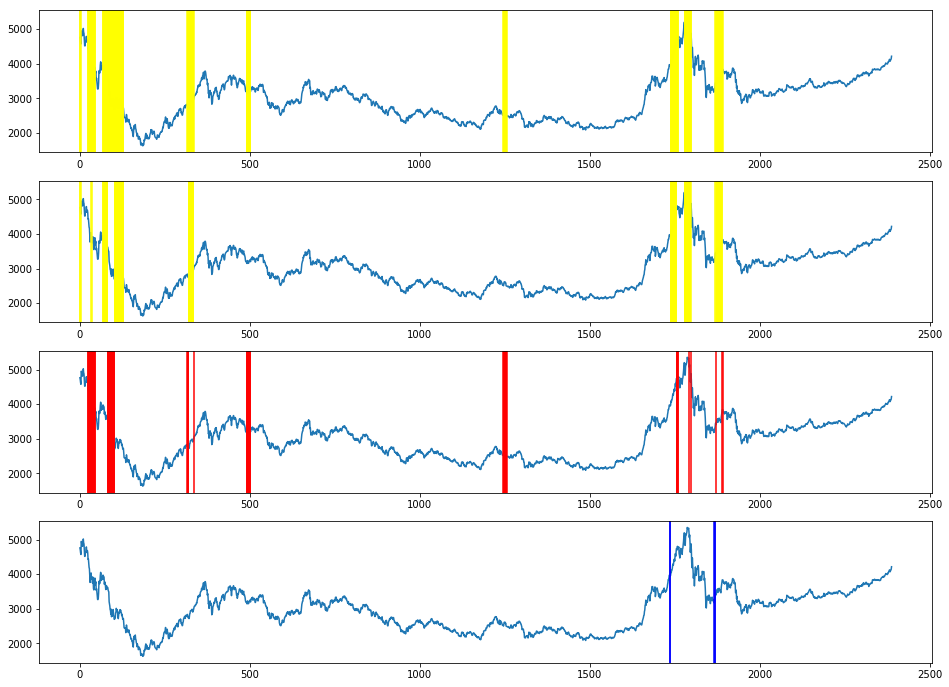

In [45]:
from matplotlib import pyplot as plt

positive_indices = [i for i, v in enumerate(label) if v == 1]
predict_positive_indices = [i for i, v in enumerate(predict) if v == 1]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

ax1.plot(df['close'].values)
ax2.plot(df['close'].values)
ax3.plot(df['close'].values)
ax4.plot(df['close'].values)

tp = [x for x in positive_indices if x in predict_positive_indices]
fn = [x for x in positive_indices if x not in predict_positive_indices]
fp = [x for x in predict_positive_indices if x not in positive_indices]

print('tp: {}, fn: {}, fp: {}'.format(len(tp), len(fn), len(fp)))

for i in positive_indices:
    ax1.axvline(x=i, c='yellow')

for i in tp:
    ax2.axvline(x=i, c='yellow')
for i in fn:
    ax3.axvline(x=i, c='red')
for i in fp:
    ax4.axvline(x=i, c='blue')
    
plt.show()
plt.close()


In train data:
All samples num: 894
Positive samples num: 116
Precision: 0.990291262136, recall: 0.879310344828
TP: 102.0, FP: 1.0, FN: 14.0
tp: 102, fn: 14, np: 1


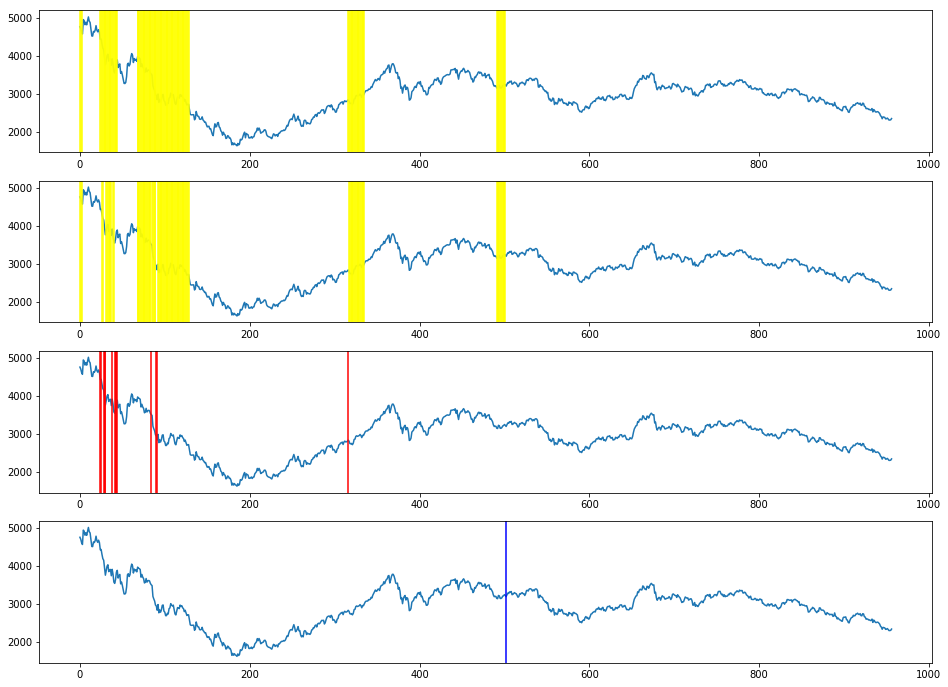

In test data:
All samples num: 1369
Positive samples num: 76
Precision: 0.0421455938697, recall: 0.144736842105
TP: 11.0, FP: 250.0, FN: 65.0
tp: 11, fn: 65, np: 250


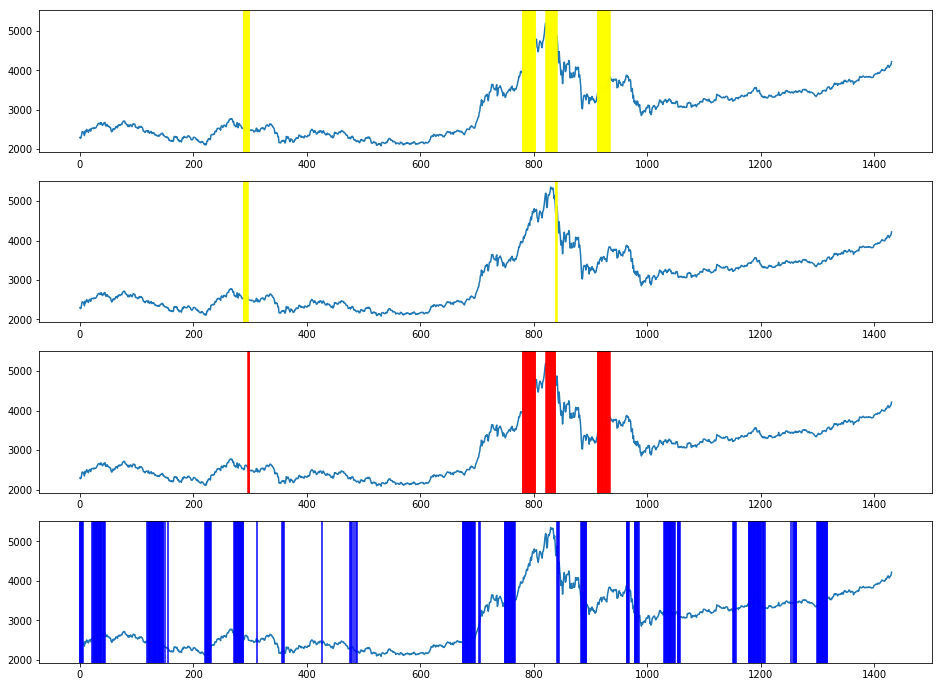

In [4]:
from python.experiment import tumble_predict_experiment
from sklearn.ensemble import GradientBoostingClassifier

split_point = df.index.tolist().index('2012-01-04')
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

model = GradientBoostingClassifier()
tumble_predict_experiment(model, df_train, df_test, train_interval=42, test_interval=21, 
                          upper_shadow_threshold=0.2, crash_threshold=0.15)


In train data:
All samples num: 894
Positive samples num: 116
Precision: 1.0, recall: 0.836206896552
TP: 97.0, FP: 0.0, FN: 19.0
tp: 97, fn: 19, np: 0


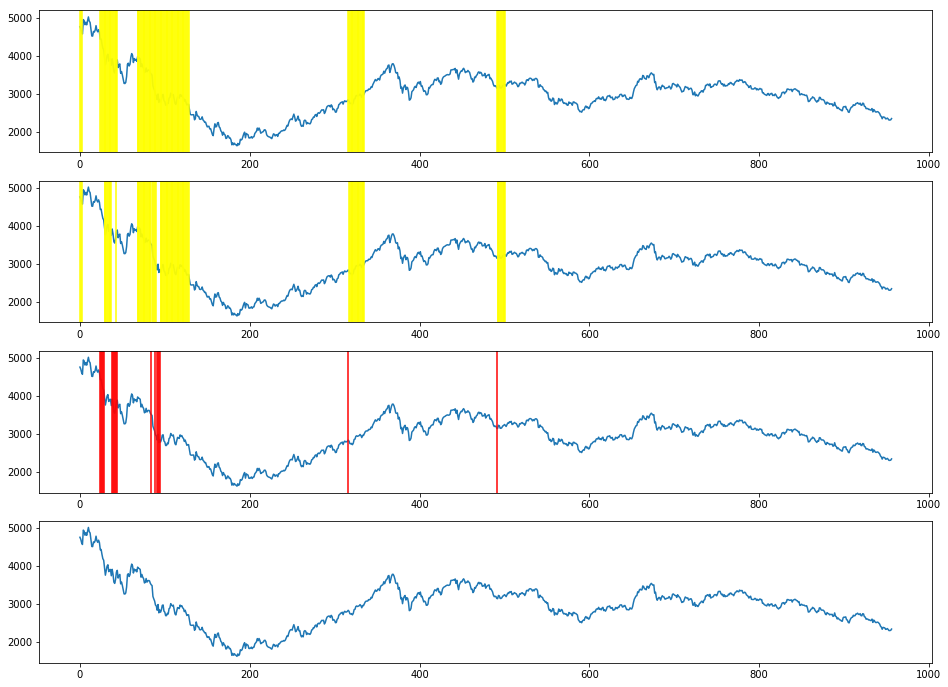

In test data:
All samples num: 1369
Positive samples num: 76
Precision: 0.0478260869565, recall: 0.144736842105
TP: 11.0, FP: 219.0, FN: 65.0
tp: 11, fn: 65, np: 219


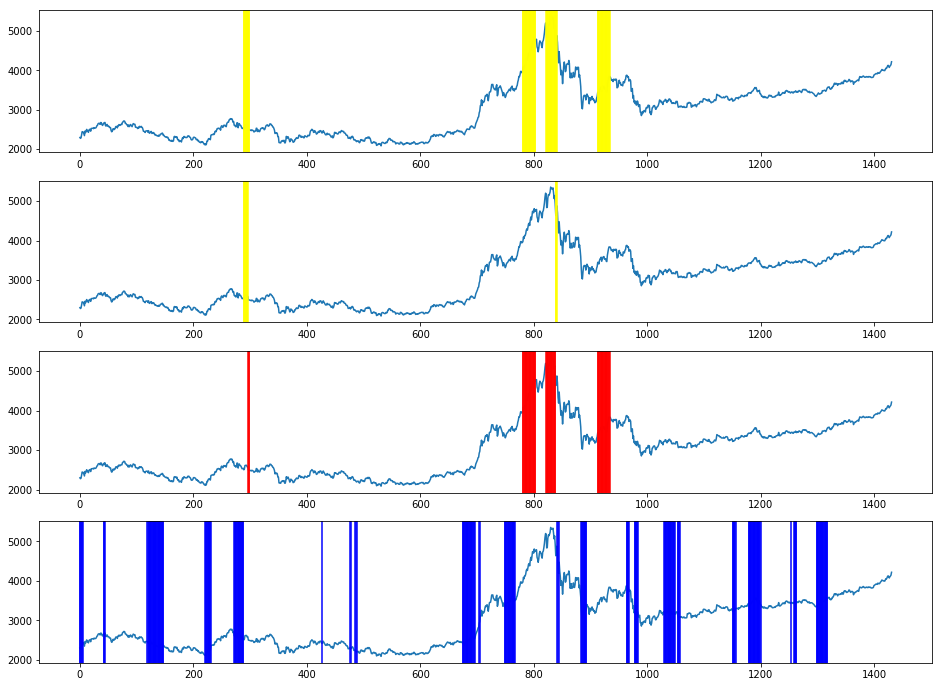

In [3]:
from python.experiment import tumble_predict_experiment
from sklearn.ensemble import GradientBoostingClassifier

split_point = df.index.tolist().index('2012-01-04')
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

model = GradientBoostingClassifier()
tumble_predict_experiment(model, df_train, df_test, train_interval=42, test_interval=21, 
                          upper_shadow_threshold=0.2, crash_threshold=0.15)


## 4. 结论